In [4]:
from agents.theoritical_agent import *
from agents.angle_agent import *
from agents.observation_agent import *
from agents.control_rnn import *
from agents.pre_rnn import *
from agents.post_rnn import *
from agents.universal_rnn import *
from env import *
import numpy as np
from tf_to_mat import *

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

2024-01-31 14:58:47.941466: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-31 14:58:47.971623: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-31 14:58:47.971657: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-31 14:58:47.972932: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-31 14:58:47.979816: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-31 14:58:47.980227: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [5]:
tf.keras.backend.set_floatx('float64')

In [6]:
#Parameters
kappa = 0.5 #Kappa for the von mises
deck_size = 12 #length sequences
optimal_training = False #Training on optimal labels instead of real ones

nb = 1 #Nb of networks to train
batch_size = 2000 #Batch size for the training (length of the training)
rnn_noise = None #Std for noisy networks (put None if you don't want a noisy network)
random_training = True #Training on sequence of random length chosen uniformely in [|1,12|]
separated_params = (10,2) #(Nb of neurons which will see the first part of the input,size of the first part of the input)

free_feedback = True #True = free feedback in the recurrent network / False = only REF -> SEQ feedbacks

activation = 'tanh' #Activation function

separated = False #Separated network

condition = 'pre'

In [7]:
if optimal_training:
    random_training = False #Random training cannot be used with random_training (technical issues)

### Training

In [8]:
env = Env(deck_size,kappa=kappa,condition=condition)
agent = UniversalRNN(50,activation=activation,noise=rnn_noise,random_training=random_training)
agent.postname = condition #Set path name for saving and loading

In [9]:
agent.train(env,1000,batch_size=batch_size,nb_fit=5,verbose=1)
agent.save('UniversalRNN-'+str(condition))

0 0.5125
1 0.5125
2 0.5065
3 0.50125
4 0.5025999999999999
5 0.5031666666666667
6 0.5029285714285715
7 0.5043124999999999
8 0.5059444444444444
9 0.5079
10 0.5141
11 0.51955
12 0.52525
13 0.5334
14 0.5401
15 0.54755
16 0.5560999999999999
17 0.5624499999999999
18 0.5690500000000001
19 0.5747
20 0.5753
21 0.57595
22 0.57965
23 0.5819
24 0.58355
25 0.5849
26 0.5844
27 0.5831500000000001
28 0.5826
29 0.58445
30 0.5848500000000001
31 0.5859
32 0.58675
33 0.5860999999999998
34 0.5870500000000001
35 0.5868
36 0.5877999999999999
37 0.5906499999999999
38 0.5910999999999998
39 0.5911
40 0.59125
41 0.59185
42 0.5913999999999999
43 0.5931500000000001
44 0.59065
45 0.5889
46 0.58815
47 0.58795
48 0.5869000000000001
49 0.5840500000000001
50 0.584
51 0.5847
52 0.58545
53 0.5852999999999999
54 0.58705
55 0.58615
56 0.58885
57 0.58935
58 0.59285
59 0.5964
60 0.5973499999999999
61 0.59805
62 0.59805
63 0.5967
64 0.59675
65 0.5996
66 0.5966
67 0.59485
68 0.5925
69 0.59175
70 0.5906
71 0.5886
72 0.5881
73 0

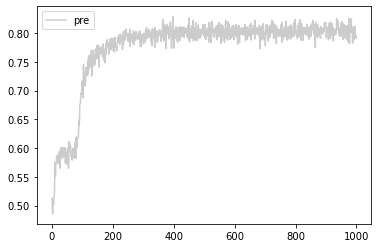

In [10]:
#Plot accuracies
plt.plot(range(len(agent.scores)),agent.scores,alpha=0.4,color='grey',label=condition)
plt.legend()
plt.show()

### Plots

In [11]:
env = Env(deck_size,kappa=kappa,condition=condition)
agent = UniversalRNN(50,activation=activation,noise=rnn_noise,random_training=random_training)
agent.postname = condition #Set path name for saving and loading

In [12]:
agent.load('UniversalRNN-'+str(condition))

LOADING ['nn', 'out_nn']


In [13]:
from sklearn.decomposition import PCA
from analyse.plot_pca import *

In [14]:
pca_batch_size = 2000 #Batch size to fit the PCA on
pca_axes = [0,1] #Axes of the pca to plot (3 max)

nb_variance = 10 #Nb of variance to plot

In [15]:
#Pre compute batch
batch_obsf = env.sample_batch(pca_batch_size) 
batch_obs = batch_obsf.get('obs')

In [16]:
#Def residue function
def residue(X,Y):
    from sklearn.linear_model import LinearRegression
    Lg = LinearRegression()
    XX = np.reshape(X,(-1,X.shape[-1]))
    YY = Y
    Lg.fit(YY,XX)
    print("score",Lg.score(YY,XX))
    #assert False
    pred = Lg.predict(YY)
    pred = np.reshape(pred,X.shape)
    return X - pred

In [31]:
out = agent.nn(batch_obs).numpy()
choice = agent.predict(batch_obsf).numpy()

In [24]:
#Residue ref
#ref = batch_obsf.get('obs')[:,:,2:].reshape((-1,2))
#out = residue(out,ref)

#Residue choice
#choice_batch = choice[:,None].repeat(out.shape[1],axis=1).reshape((-1,1))
#out = residue(out, choice_batch)

In [32]:
#fit pca
pca = fit_pca(out.reshape((-1,50)),nb_components=nb_variance)
pca_batch = pca.transform(out.reshape((-1,50))).reshape(out.shape[:-1]+(nb_variance,))

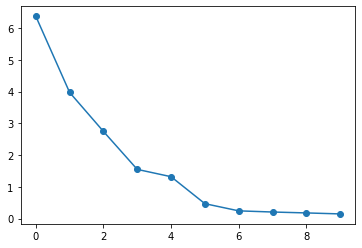

In [33]:
%matplotlib inline
#plot explained variance
plt.plot(range(nb_variance),pca.explained_variance_,marker='o')
plt.show()

In [27]:
#Plot background function
def plot_bg(pca_batch,zorder=0):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('pca1')
    ax.set_ylabel('pca2')
    ax.set_zlabel('pca3')
    colors = [(i/deck_size,(1-i/deck_size),(i-6)**2/36) for i in range(pca_batch.shape[1])]
    for i in range(pca_batch.shape[1]):
        ax.scatter(pca_batch[:,i,0],pca_batch[:,i,1],pca_batch[:,i,2],color=colors[i],alpha=0.1,marker='.',zorder=zorder)

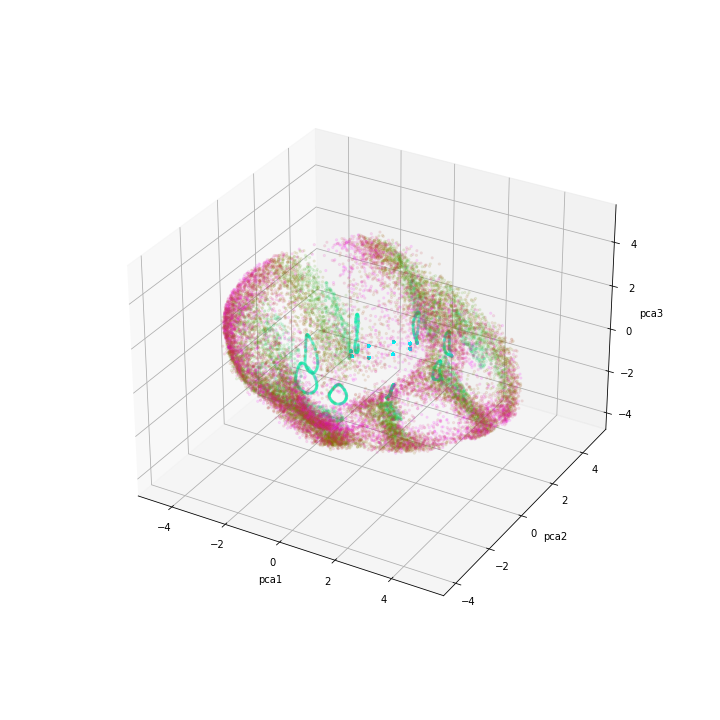

In [28]:
%matplotlib widget
from mpl_toolkits import mplot3d
plot_bg(pca_batch)
plt.show()